# Mapping human lymph node cell types to 10X Visium - estimating reference expression signatures

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vitkl/cell2location-sandbox/blob/master/notebooks/scvi_real_data/cell2location_analysis_3_scvi_ln.ipynb)

Cell2location maps cell types by integrating single cell/nucleus and spatial transcriptomics data. This is achieved by estimating which combination of cell types in which cell abundance could have given the mRNA counts in the spatial data, taking technical effects into account (platform/technology effect, contaminating RNA, unexplained variance).

Given cell type annotation for each cell, the corresponding reference cell type signatures $g_{f,g}$, which represent the average mRNA count of each gene $g$ in each cell type $f={1, .., F}$, can be estimated from sc/snRNA-seq data using 2 provided methods (see below). Cell2location needs untransformed unnormalised spatial mRNA counts as input. You also need to provide cell2location with the expected average cell abundance per location which is used as a prior to guide estimation of absolute cell abundance. This value depends on the tissue and can be estimated by counting nuclei for a few locations in the paired histology image but can be approximate (see paper methods for more guidance).

We provide 2 methods for estimating reference expression signatures of cell types from scRNA-seq data:

1) a statistical method based on Negative Binomial regression. We generally recommend using NB regression, which allows to robustly combine data across technologies and batches, which results in improved spatial mapping accuracy. This notebook shows use a dataset composed on multiple batches and technologies to estimate that. 

2) hard-coded computation of per-cluster average mRNA counts for individual genes (`scvi.external.cell2location.compute_cluster_averages`). When the batch effects are small, this faster hard-coded method of computing per cluster averages provides similarly high accuracy. We also recommend the hard-coded method for non-UMI technologies such as Smart-Seq 2.


### Contents:
* [Loading packages](#Loading_packages)
* [Loading Visium data](#Loading_Visium)
* [Load refence cell type expression signatures](#Loading_signatures)
* [Run scvi-cell2location](#cell2location)
* [Leiden clustering of cell abundance](#region_clustering)




### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "pyro-cell2location"
user = "vitkl"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/$user/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [2]:
import sys
if not IN_COLAB:
    sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

#import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

## Loading Visium data <a class="anchor" id="Loading_Visium"></a>

First let's read spatial Visium data from 10X Space Ranger output.

In [3]:
results_folder = './results/lymph_nodes_analysis/'
scvi_run_name = f'{results_folder}/amortised/signatures_v1'

adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Load reference cell type expression signatures <a class="anchor" id="Loading_signatures"></a>

The signatures were estimated from scRNA-seq data, accounting for batch effect, using a separate model, as shown here: https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_estimating_signatures.html

Here we download the h5ad object with results:

In [4]:
import os
if not os.path.exists('./data/sc.h5ad'):
    !cd ./data/ && wget https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad 

In [5]:
# read data
adata_snrna_raw = sc.read(f'./data/sc.h5ad')

adata_snrna_raw.var['SYMBOL'] = adata_snrna_raw.var.index 
adata_snrna_raw.var.index = adata_snrna_raw.var['GeneID-2'].copy()
adata_snrna_raw.var_names = adata_snrna_raw.var['GeneID-2'].copy()
adata_snrna_raw.var.index.name = None
adata_snrna_raw.raw.var['SYMBOL'] = adata_snrna_raw.raw.var.index
adata_snrna_raw.raw.var.index = adata_snrna_raw.raw.var['GeneID-2'].copy()
adata_snrna_raw.raw.var.index.name = None

# prepare anndata for scVI model
scvi.data.setup_anndata(adata=adata_snrna_raw, batch_key='Sample', labels_key='Subset',
                        categorical_covariate_keys=['Method']
                       )
scvi.data.view_anndata_setup(adata_snrna_raw)

INFO     Using batches from adata.obs["Sample"]                                              
INFO     Using labels from adata.obs["Subset"]                                               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/ca

INFO     Successfully registered anndata object containing 73260 cells, 10237 vars, 23       
         batches, 34 labels, and 0 proteins. Also registered 1 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [6]:
adata_snrna_raw.uns['_scvi']['extra_categoricals']['n_cats_per_key']

[2]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/150:   0%|          | 0/150 [00:00<?, ?it/s]

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  warnings.warn(*args, **kwargs)


Epoch 150/150: 100%|██████████| 150/150 [14:29<00:00,  5.80s/it, v_num=1, train_loss_step=2.49e+8, train_loss_epoch=2.51e+8]


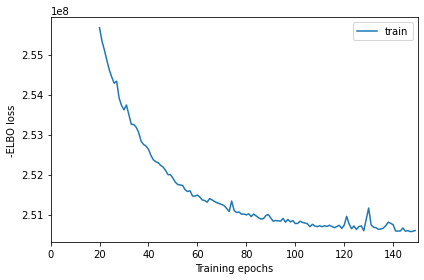

In [7]:
# create and train the model
from scvi.external.cell2location._reference_module import RegressionModel
mod = RegressionModel(
    adata_snrna_raw,
    amortised=True, single_encoder=True,
    encoder_kwargs={'dropout_rate': 0.2},
    #init_vals = {'per_cluster_mu_fg': per_cluster_mu_fg}
) 

mod.train(max_epochs=150, 
          batch_size=2500, 
          plan_kwargs={"optim_kwargs": {"lr": 0.01}},
          use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [8]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_snrna_raw = mod.export_posterior(
    adata_snrna_raw, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{scvi_run_name}_ref", overwrite=True)
# can be loaded later like this:
# mod = scvi.external.Cell2location.load(f"{scvi_run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{scvi_run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:18<00:00, 55.37it/s]


... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


'./results/lymph_nodes_analysis//amortised/signatures_v1/sp.h5ad'

In [9]:
mod.factor_names_

array(['B_Cycling', 'B_GC_DZ', 'B_GC_LZ', 'B_GC_prePB', 'B_IFN',
       'B_activated', 'B_mem', 'B_naive', 'B_plasma', 'B_preGC',
       'DC_CCR7+', 'DC_cDC1', 'DC_cDC2', 'DC_pDC', 'Endo', 'FDC', 'ILC',
       'Macrophages_M1', 'Macrophages_M2', 'Mast', 'Monocytes', 'NK',
       'NKT', 'T_CD4+', 'T_CD4+_TfH', 'T_CD4+_TfH_GC', 'T_CD4+_naive',
       'T_CD8+_CD161+', 'T_CD8+_cytotoxic', 'T_CD8+_naive', 'T_TIM3+',
       'T_TfR', 'T_Treg', 'VSMC'], dtype=object)

Examine QC plots

1. Reconstruction accuracy to assess if there are any issues with inference.

2. The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.

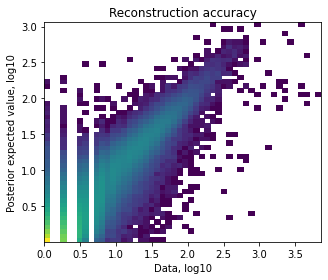

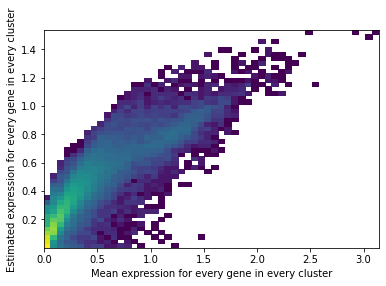

In [10]:
mod.plot_QC()

In [11]:
adata_snrna_raw.var

GeneID-2   GeneName-2    feature_types  \
ENSG00000188976  ENSG00000188976        16551              nan   
ENSG00000188290  ENSG00000188290        11070              nan   
ENSG00000187608  ENSG00000187608        12375              nan   
ENSG00000186891  ENSG00000186891        31000              nan   
ENSG00000186827  ENSG00000186827        30985              nan   
...                          ...          ...              ...   
IGL_VDJsum            IGL_VDJsum   IGL_VDJsum  Gene Expression   
TCRA_VDJsum          TCRA_VDJsum  TCRA_VDJsum  Gene Expression   
TCRB_VDJsum          TCRB_VDJsum  TCRB_VDJsum  Gene Expression   
TCRD_VDJsum          TCRD_VDJsum  TCRD_VDJsum  Gene Expression   
TCRG_VDJsum          TCRG_VDJsum  TCRG_VDJsum  Gene Expression   

                 feature_types-0  feature_types-1       gene_ids-1  \
ENSG00000188976  Gene Expression  Gene Expression  ENSG00000188976   
ENSG00000188290  Gene Expression  Gene Expression  ENSG00000188290   
ENSG00000187608  Gene Expression  Gene Expression  ENSG00000187608   
ENSG00000186891  Gene Expression  Gene Expression  ENSG00000186891   
ENSG00000186827  Gene Expression  Gene Expression  ENSG00000186827   
...                          ...              ...              ...   
IGL_VDJsum       Gene Expression  Gene Expression       IGL_VDJsum   
TCRA_VDJsum      Gene Expression  Gene Expression      TCRA_VDJsum   
TCRB_VDJsum      Gene Expression  Gene Expression      TCRB_VDJsum   
TCRD_VDJsum      Gene Expression  Gene Expression      TCRD_VDJsum   
TCRG_VDJsum      Gene Expression  Gene Expression      TCRG_VDJsum   

                gene_ids-4861STDY7135913-0 gene_ids-4861STDY7135914-0  \
ENSG00000188976            ENSG00000188976            ENSG00000188976   
ENSG00000188290            ENSG00000188290            ENSG00000188290   
ENSG00000187608            ENSG00000187608            ENSG00000187608   
ENSG00000186891            ENSG00000186891            ENSG00000186891   
ENSG00000186827            ENSG00000186827            ENSG00000186827   
...                                    ...                        ...   
IGL_VDJsum                      IGL_VDJsum                 IGL_VDJsum   
TCRA_VDJsum                    TCRA_VDJsum                TCRA_VDJsum   
TCRB_VDJsum                    TCRB_VDJsum                TCRB_VDJsum   
TCRD_VDJsum                    TCRD_VDJsum                TCRD_VDJsum   
TCRG_VDJsum                    TCRG_VDJsum                TCRG_VDJsum   

                gene_ids-4861STDY7208412-0 gene_ids-4861STDY7208413-0  ...  \
ENSG00000188976            ENSG00000188976            ENSG00000188976  ...   
ENSG00000188290            ENSG00000188290            ENSG00000188290  ...   
ENSG00000187608            ENSG00000187608            ENSG00000187608  ...   
ENSG00000186891            ENSG00000186891            ENSG00000186891  ...   
ENSG00000186827            ENSG00000186827            ENSG00000186827  ...   
...                                    ...                        ...  ...   
IGL_VDJsum                      IGL_VDJsum                 IGL_VDJsum  ...   
TCRA_VDJsum                    TCRA_VDJsum                TCRA_VDJsum  ...   
TCRB_VDJsum                    TCRB_VDJsum                TCRB_VDJsum  ...   
TCRD_VDJsum                    TCRD_VDJsum                TCRD_VDJsum  ...   
TCRG_VDJsum                    TCRG_VDJsum                TCRG_VDJsum  ...   

                q95_per_cluster_mu_fg_T_CD4+_TfH  \
ENSG00000188976                         0.165690   
ENSG00000188290                         0.062602   
ENSG00000187608                         0.221253   
ENSG00000186891                         0.024112   
ENSG00000186827                         0.180893   
...                                          ...   
IGL_VDJsum                              0.004740   
TCRA_VDJsum                             2.317147   
TCRB_VDJsum                             3.011082   
TCRD_VDJsum                             0.033532   
TCRG

In [12]:
# export estimated expression in each cluster
inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}' 
                                for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']
inf_aver

B_Cycling   B_GC_DZ   B_GC_LZ  B_GC_prePB     B_IFN  \
ENSG00000188976   0.321229  0.237984  0.273218    0.337760  0.149280   
ENSG00000188290   0.002954  0.001268  0.001629    0.061874  0.047299   
ENSG00000187608   0.216431  0.144805  0.190485    0.367850  3.307150   
ENSG00000186891   0.017279  0.001292  0.055868    0.078081  0.012553   
ENSG00000186827   0.008646  0.001018  0.008549    0.034750  0.013677   
...                    ...       ...       ...         ...       ...   
IGL_VDJsum        1.877843  1.830257  0.899877    2.674527  0.951298   
TCRA_VDJsum       0.020048  0.002579  0.011504    0.049698  0.004009   
TCRB_VDJsum       0.027666  0.000781  0.005676    0.006503  0.007675   
TCRD_VDJsum       0.000997  0.003400  0.003199    0.194932  0.028259   
TCRG_VDJsum       0.012858  0.013889  0.015730    0.027983  0.026180   

                 B_activated     B_mem   B_naive   B_plasma   B_preGC  ...  \
ENSG00000188976     0.188104  0.164447  0.163589   0.220458  0.348493  ...   
ENSG00000188290     0.015345  0.031771  0.008698   0.002256  0.022212  ...   
ENSG00000187608     0.100951  0.169773  0.106086   0.246260  0.068147  ...   
ENSG00000186891     0.006629  0.004818  0.001688   0.149002  0.133404  ...   
ENSG00000186827     0.002298  0.006116  0.001849   0.079853  0.049749  ...   
...                      ...       ...       ...        ...       ...  ...   
IGL_VDJsum          0.812095  0.718009  0.764259  18.721441  0.893279  ...   
TCRA_VDJsum         0.003433  0.002624  0.000839   0.041694  0.004425  ...   
TCRB_VDJsum         0.004105  0.005142  0.003965   0.060478  0.001882  ...   
TCRD_VDJsum         0.001080  0.000716  0.000574   0.003242  0.006965  ...   
TCRG_VDJsum         0.010751  0.009562  0.007224   0.030145  0.007432  ...   

                 T_CD4+_TfH  T_CD4+_TfH_GC  T_CD4+_naive  T_CD8+_CD161+  \
ENSG00000188976    0.147915       0.149904      0.190510       0.137963   
ENSG00000188290    0.051932       0.038221      0.065195       0.017180   
ENSG00000187608    0.200590       0.311397      0.272306       0.234645   
ENSG00000186891    0.018467       0.313454      0.003847       0.064278   
ENSG00000186827    0.158538       0.645829      0.038953       0.056449   
...                     ...            ...           ...            ...   
IGL_VDJsum         0.003350       0.002498      0.004665       0.008437   
TCRA_VDJsum        2.169557       1.964610      1.916691       1.831588   
TCRB_VDJsum        2.838106       4.470934      2.489160       1.861928   
TCRD_VDJsum        0.025347       0.023543      0.022554       0.136012   
TCRG_VDJsum        0.078478       0.132485      0.035904       0.670598   

                 T_CD8+_cytotoxic  T_CD8+_naive   T_TIM3+     T_TfR    T_Treg  \
ENSG00000188976          0.137802      0.223593  0.247638  0.180790  0.160470   
ENSG00000188290          0.007698      0.022131  0.116994  0.357220  0.070528   
ENSG00000187608          0.295421      0.334166  1.281018  0.472070  0.275224   
ENSG00000186891          0.017862      0.001708  0.247958  1.015710  0.402018   
ENSG00000186827          0.019114      0.002815  0.349681  1.787104  0.821532   
...                           ...           ...       ...       ...       ...   
IGL_VDJsum               0.011277      0.002895  0.013191  0.007427  0.005920   
TCRA_VDJsum              1.777070      1.714702  2.738291  2.256799  2.734582   
TCRB_VDJsum              2.431005      2.112374  4.244463  4.961377  3.272142   
TCRD_VDJsum              0.074711      0.037064  0.081966  0.020850  0.024964   
TCRG_VDJsum              0.810917      0.122521  0.253735  0.066396  0.023464   

                     VSMC  
ENSG00000188976  0.238677  
ENSG00000188290  1.353284  
ENSG00000187608  0.318496  
ENSG00000186891  0.046512  
ENSG00000186827  0.040267  
...                   ...  
IGL_VDJsum       0.012911  
TCRA_VDJsum      0.267044  
TCRB_VDJsum      0.117352  
TCRD_VDJsum      0.295868  
TCRG_VDJsum      0.031894  

[102

## Train scvi-cell2location <a class="anchor" id="scvi-cell2location"></a>

In [13]:
# rename genes to ENSEMBL
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var_names = adata_vis.var['gene_ids']
adata_vis.var_names.name = None

In [14]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for scVI model
scvi.data.setup_anndata(adata=adata_vis, batch_key="sample")
scvi.data.view_anndata_setup(adata_vis)

INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             


/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 4035 cells, 10217 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/700:   0%|          | 0/700 [00:00<?, ?it/s]

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  warnings.warn(*args, **kwargs)


Epoch 700/700: 100%|██████████| 700/700 [04:42<00:00,  2.48it/s, v_num=1, train_loss_step=4.11e+7, train_loss_epoch=4.1e+7] 


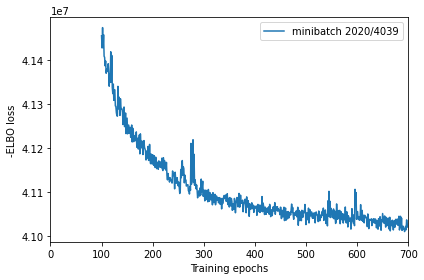

In [15]:
# create and train the model
mod = scvi.external.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    amortised=True, single_encoder=True,
    encoder_kwargs={'dropout_rate': 0.2},
    # the expected average cell abundance - user-provided, tissue-dependent hyper-prior:
    N_cells_per_location=30) 

mod.train(max_epochs=700, 
          batch_size=2020, 
          plan_kwargs={"optim_kwargs": {"lr": 0.01}},
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(100)
plt.legend(labels=['minibatch 2020/4039']);

In [16]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': 2020, 'use_gpu': True}
)

# Save model
mod.save(f"{scvi_run_name}_c2l", overwrite=True)
# can be loaded later like this:
# mod = scvi.external.Cell2location.load(f"{scvi_run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{scvi_run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:27<00:00, 36.25it/s]


... storing 'SYMBOL' as categorical


'./results/lymph_nodes_analysis//amortised/signatures_v1/sp.h5ad'

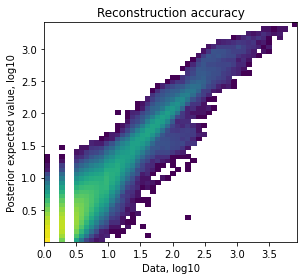

In [17]:
# Examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
mod.plot_QC()

### Plot cell abundance in spatial coordinates

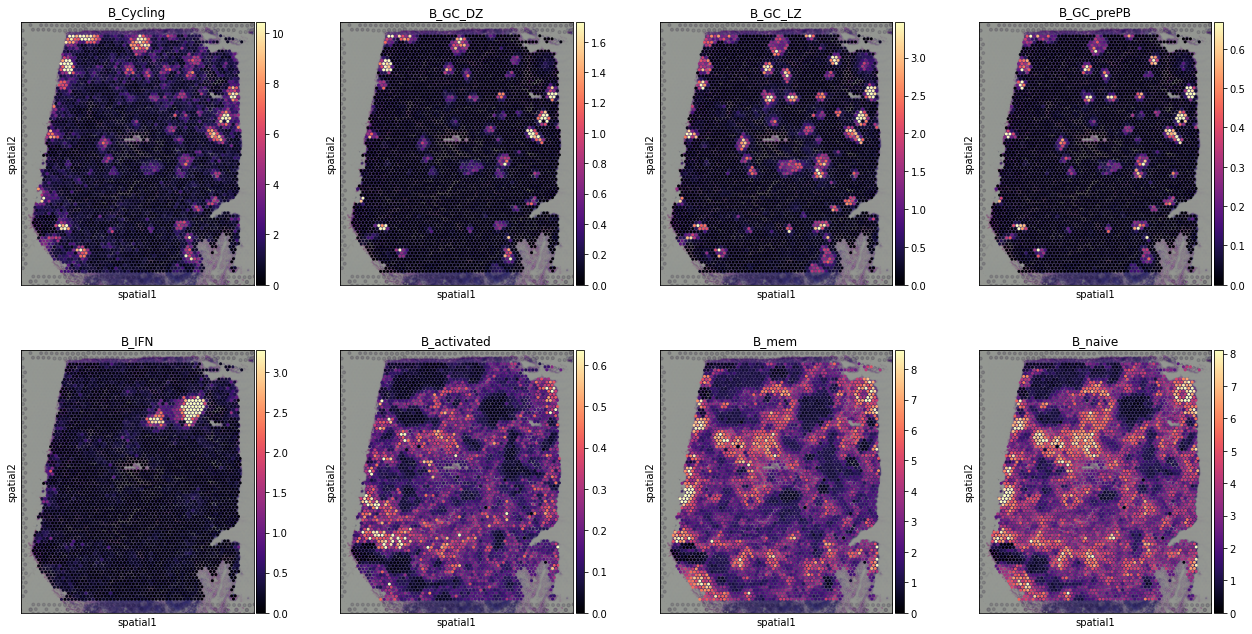

In [18]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, cmap='magma',
                  # show first 8 cell types
                  color=adata_vis.uns['mod']['factor_names'][0:8], 
                  ncols=4, size=1.3, 
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2' 
                 )

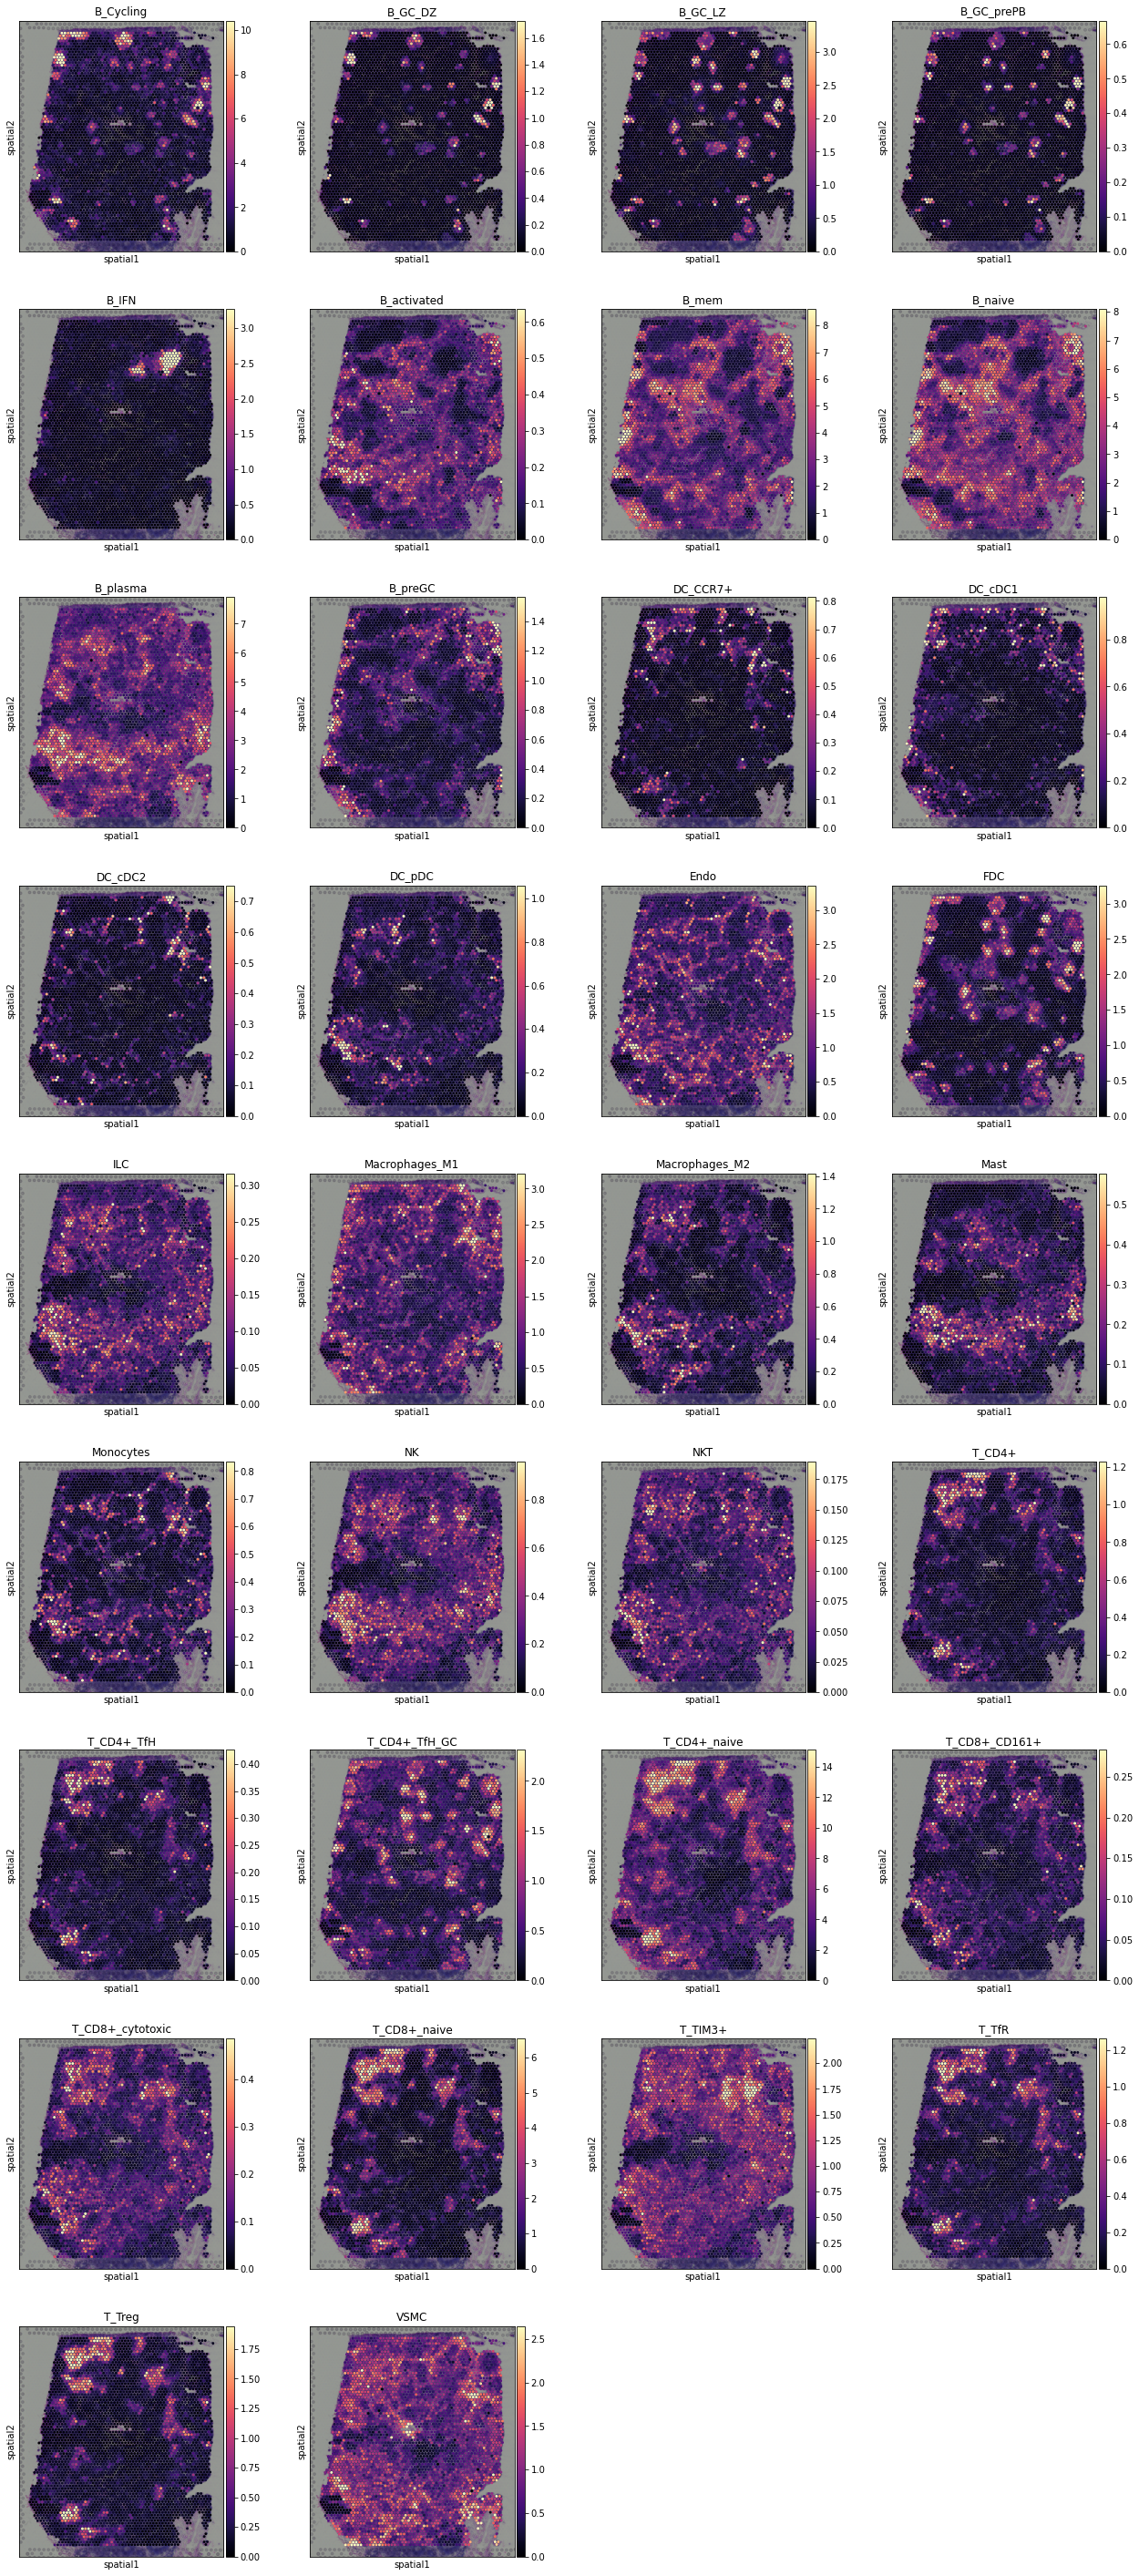

In [19]:
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, cmap='magma',
                  color=adata_vis.uns['mod']['factor_names'], 
                  ncols=4, size=1.3, 
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2' 
                 )

## Perform clustering of cell abudance estimates to identify tissue regions <a class="anchor" id="region_clustering"></a>

We find regions by clustering locations/spots (Leiden) based on estimated cell abundance of each cell type. Results are saved in `adata_vis.obs['region_cluster']`.

In [20]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 20)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")

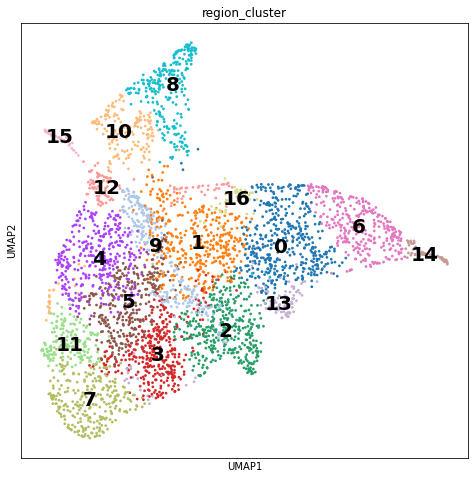

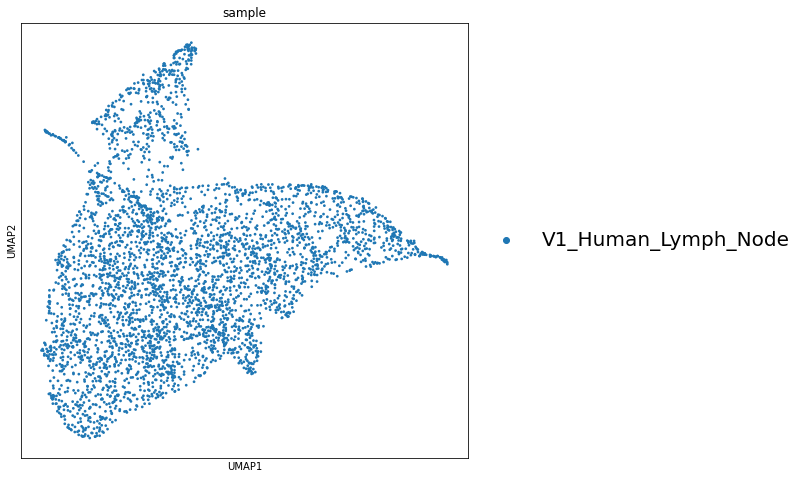

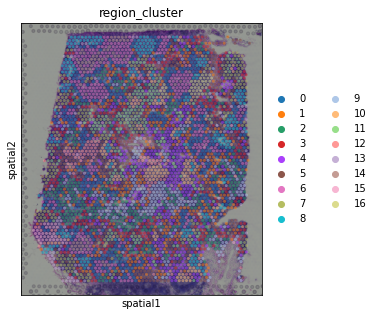

In [21]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    sc.pl.umap(adata_vis, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 2,
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'], 
                  size=1.3, img_key='hires', alpha=0.5)

### Advanced use examples

In [22]:
# Get posterior distribution samples for specific variables
samples_w_sf = mod.sample_posterior(num_samples=1000, use_gpu=True, return_samples=True,
                                    batch_size=2020,
                                    return_sites=['w_sf', 'm_g', 'u_sf_mRNA_factors'])
# samples_w_sf['posterior_samples'] contains 1000 samples as arrays with dim=(num_samples, ...)
samples_w_sf['posterior_samples']['w_sf'].shape

Sampling global variables, sample: 100%|██████████| 999/999 [00:26<00:00, 37.69it/s]


(1000, 4035, 34)

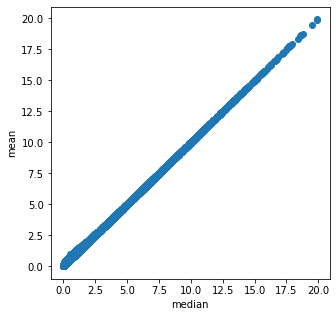

In [23]:
# Compute any quantile of the posterior distribution
medians = mod.posterior_quantile(q=0.5, use_gpu = True)

with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [5, 5]}):
    plt.scatter(medians['w_sf'].flatten(), mod.samples['post_sample_means']['w_sf'].flatten());
    plt.xlabel('median');
    plt.ylabel('mean');

Modules and their versions used for this analysis

In [24]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.20.0
IPython.core.release 7.20.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.7.4
pexpect 4.8.0
ptyprocess 0.7.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.8
wcwidth 0.2.5
jedi 0.17.0
parso 0.8.1
colorama 0.4.4
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 20.0.0
zmq.backend.cython 40303
zmq.backend.cython.constants 40303
zmq.sugar 20.0.0
zmq.sugar.constants 40303
zmq.sugar.version 20.0.0
jupyter_core 4.7.1
jupyter_core.version 4.7.1
_curses b'2.2'
dateutil 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
distutils 3.7.9
scanpy 1.7.0
scanpy._metadata 1.7.0
packaging 20.9
packaging.__about__ 20.9
importlib_metadata 1.7.0
csv 1.0
_csv 1.0
numpy 1.20.0
numpy.core 1.20.0
numpy.core._multiarray_umath 3.1
numpy.lib 1.20.0
numpy.linalg.